In [1]:
# ! pip install tensorflow

In [2]:
# ! pip install keras-tuner


In [3]:
import zipfile
import os

import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel
from keras_tuner import RandomSearch

import matplotlib.pyplot as plt
from PIL import Image

In [4]:
# with zipfile.ZipFile('archive.zip', 'r') as zip_ref:
#     zip_ref.extractall('folder')

In [5]:
print(os.listdir('folder'))

['test', 'train']


In [6]:
train_dir = 'folder/train'
test_dir = 'folder/test'

train_data_gen = ImageDataGenerator(rescale=1./255) # normalize pixel vals
test_data_gen = ImageDataGenerator(rescale=1./255)

train_gen = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(64, 64),  #image size
    batch_size = 32,
    class_mode = 'categorical'  # since its multi-class classification
)

test_gen = test_data_gen.flow_from_directory(
    test_dir,
    target_size = (64, 64),
    batch_size = 32,
    class_mode = 'categorical'
)

print(train_gen.class_indices)
print(test_gen.class_indices)

Found 28709 images belonging to 7 classes.
Found 7179 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [7]:
def count_images(directory):
    folder_counts = {}
    total_count = 0
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        image_files = [file for file in os.listdir(folder_path)]
        folder_counts[folder] = len(image_files)
        total_count += len(image_files)
    return folder_counts, total_count

train_counts, total_train_images = count_images(train_dir)
test_counts, total_test_images = count_images(test_dir)

print(f'Total images in the Train Folder: \n{total_train_images}\n')
print(f'Number of images in each folder of the Train dataset: \n{train_counts}\n')

print(f'Total images in the Test Folder: \n{total_test_images}\n')
print(f'Number of images in each folder of the Test dataset: \n{test_counts}')

Total images in the Train Folder: 
28709

Number of images in each folder of the Train dataset: 
{'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}

Total images in the Test Folder: 
7179

Number of images in each folder of the Test dataset: 
{'angry': 959, 'disgust': 111, 'fear': 1024, 'happy': 1774, 'neutral': 1233, 'sad': 1247, 'surprise': 831}


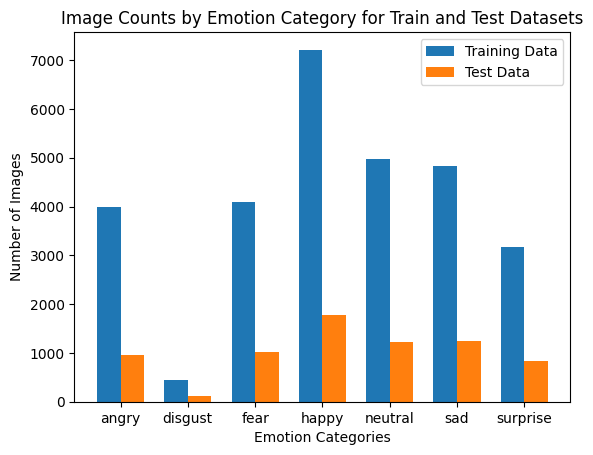

In [8]:
categories = list(train_counts.keys())
train_values = list(train_counts.values())
test_values = list(test_counts.values())

bar_width = 0.35
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]

plt.bar(r1, train_values, width=bar_width, label='Training Data')
plt.bar(r2, test_values, width=bar_width, label='Test Data')

plt.xlabel('Emotion Categories')
plt.ylabel('Number of Images')
plt.title('Image Counts by Emotion Category for Train and Test Datasets')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories)
plt.legend()
plt.show()

In [9]:
# ! pip install Pillow

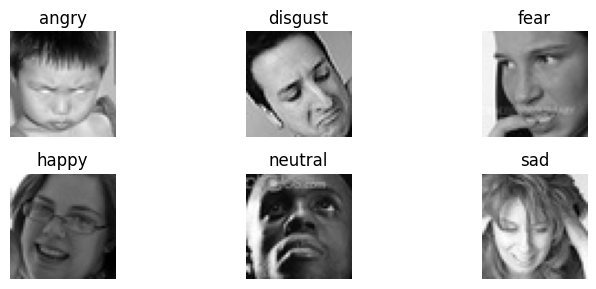

In [10]:
images = []
labels = []

for emotion in os.listdir('folder/train'):
    emotion_path = os.path.join('folder/train', emotion)
    img_path = os.path.join(emotion_path, os.listdir(emotion_path)[0])
    images.append(img_path)
    labels.append(emotion)
        
num_images_to_display = 6

fig, axes = plt.subplots(2, 3, figsize=(8, 3))
axes = axes.flatten()

for i in range(num_images_to_display):
    img = Image.open(images[i]).convert('L')  # Convert to grayscale (black and white)
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(labels[i])
    axes[i].axis('off')  
    
plt.tight_layout()
plt.show()

In [11]:
# Build a Sequential model
model = Sequential()

# Convolutional Layer: 
# 1st layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))  # Input shape should match your image size
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output from the convolutional layers
model.add(Flatten())

# Fully connected (Dense) layers
model.add(Dense(128, activation='relu'))  # Can increase/decrease units as needed
model.add(Dropout(0.5))  # Dropout to avoid overfitting

# Output layer with softmax for multi-class classification
model.add(Dense(len(train_counts), activation='softmax'))

C:\Users\kosht\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),  # You can experiment with learning rate
              loss='categorical_crossentropy',  # Since this is multi-class classification
              metrics=['accuracy'])

# Print model summary to see the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 684,103 (2.61 MB)

 Trainable params: 684,103 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    validation_data=test_gen,
    validation_steps=test_gen.samples // test_gen.batch_size,
    epochs=15  # Can adjust based on your training time/resources
)

Epoch 1/15


C:\Users\kosht\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 32s 33ms/step - accuracy: 0.2611 - loss: 1.7899 - val_accuracy: 0.3987 - val_loss: 1.5562
Epoch 2/15
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 0.5625 - loss: 1.2871 - val_accuracy: 0.5455 - val_loss: 1.2543
Epoch 3/15
  2/897 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - accuracy: 0.5000 - loss: 1.4678 

C:\Users\kosht\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.4042 - loss: 1.5205 - val_accuracy: 0.4862 - val_loss: 1.3439
Epoch 4/15
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 50us/step - accuracy: 0.4688 - loss: 1.3160 - val_accuracy: 0.5455 - val_loss: 1.4637
Epoch 5/15
897/897 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.4779 - loss: 1.3656 - val_accuracy: 0.5008 - val_loss: 1.2933
Epoch 6/15
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 47us/step - accuracy: 0.4688 - loss: 1.3946 - val_accuracy: 0.5455 - val_loss: 1.3621
Epoch 7/15
897/897 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.5097 - loss: 1.2915 - val_accuracy: 0.5266 - val_loss: 1.2397
Epoch 8/15
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 0.5000 - loss: 1.2282 - val_accuracy: 0.3636 - val_loss: 1.6243
Epoch 9/15
897/897 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.5353 - loss: 1.2194 - val_accuracy: 0.5282 - val_loss: 1.2144
Epoch 10/15
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 46us/step - accuracy: 0.6562 - loss: 0.9596 - val_accuracy: 

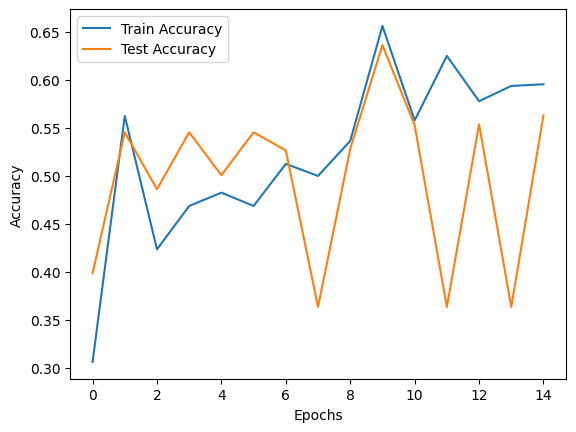

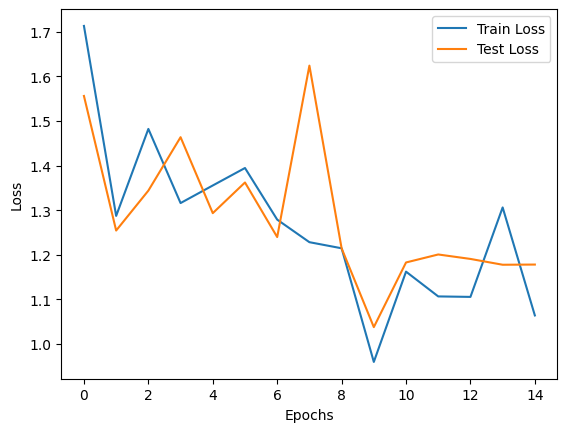

In [14]:
# Plot training & validation accuracy and loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
# Evaluate the model on the validation set
test_loss, test_acc = model.evaluate(test_gen)
print(f"Validation Accuracy: {test_acc * 100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.5614 - loss: 1.1931
Validation Accuracy: 56.32%


In [31]:
model.save('emotion_recognition_cnn.h5')  